Integración completada con éxito: True
Tiempo total de simulación: 200000 s


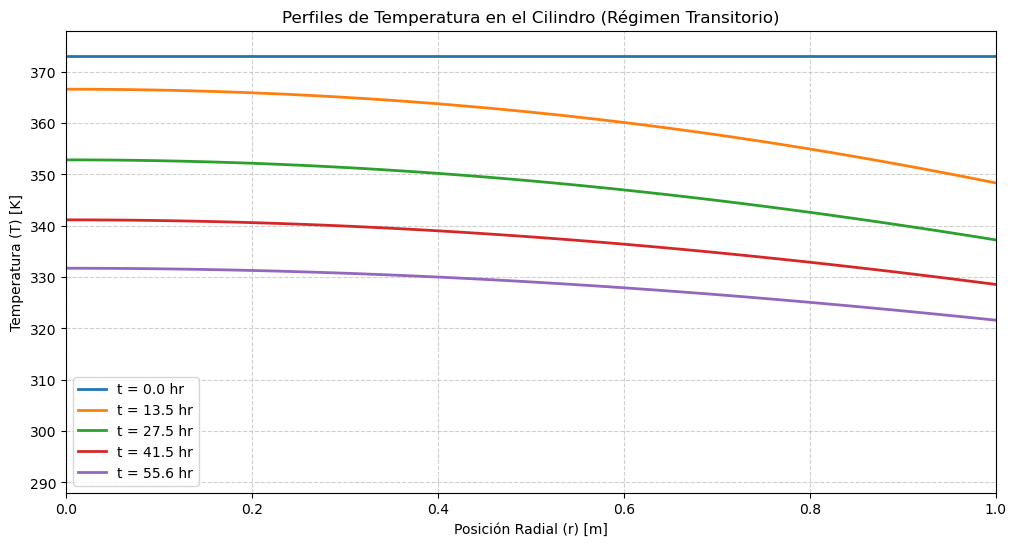

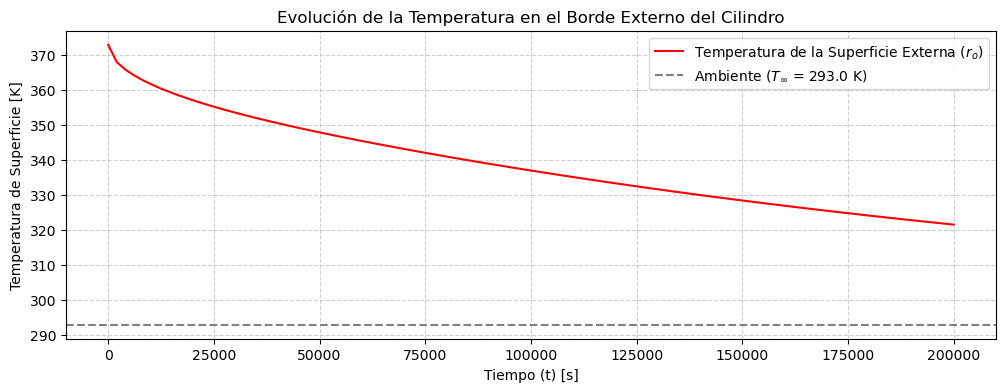

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# =========================================================================
# 1. PARÁMETROS FÍSICOS Y GEOMÉTRICOS (Definición Global)
# =========================================================================

# Parámetros físicos (Valores típicos para acero)
k = 15.0          # Conductividad térmica [W/m·K]
rho = 7800.0      # Densidad [kg/m3]
cp = 500.0        # Calor específico [J/kg·K]
alpha = k / (rho * cp)  # Difusividad térmica [m2/s] (alpha ≈ 3.846e-6)

# Condiciones térmicas
h = 10.0           # Coeficiente convectivo [W/m2·K]
T_inf = 293.0      # Temperatura del aire ambiente [K]
Ti = 373.0         # Temperatura inicial del estanque [K]

# Geometría del estanque
ri = 0.0          # Radio interno (Eje de simetría) [m]
ro = 1.0          # Radio externo [m]

# Parámetros Numéricos
N = 100                    # Número de nodos
dr = (ro - ri) / (N - 1)   # Espaciado radial [m]
r = np.linspace(ri, ro, N)


# =========================================================================
# 2. FUNCIÓN DE LA DERIVADA TEMPORAL (dT/dt = A*T + b)
# =========================================================================

def dTdt(t, T):
    # --- Parámetros y Geometría ---
    # Asumimos que N, dr, r, alpha, k, h, rho, cp, T_inf están definidos globalmente.
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)

    # 5. CB1 Interna (Eje Central, i=0) - OK
    A[0, 0] = -4 * alpha / dr**2
    A[0, 1] = 4 * alpha / dr**2
    b[0] = 0

    # 4. Nodos interiores (1 <= i <= N-2) - OK
    for i in range(1, N - 1):
        r_i = r[i]
        A[i, i-1] = alpha * (1/dr**2 - 1/(2*r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(2*r_i*dr)) 
        b[i] = 0

    # 6. CB2 Externa (i=N-1) - ¡CAMBIO CLAVE A BALANCE DE ENERGÍA!
    # EDO: dTn/dt = (Conducción desde N-1) - (Convección hacia T_inf)
    
    # A[N-1, N-2]: Conducción entrante (alpha / dr^2, asumiendo diferencia hacia atrás)
    A[N_last, N_last - 1] = alpha / dr**2
    
    # A[N-1, N-1]: Coeficiente de T_N (Conducción saliente + Convección saliente)
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    
    # b[N-1]: Término fuente de la convección (INCLUYE T_inf)
    b[N_last] = h * T_inf / (rho * cp * dr)

    # 7. CÁLCULO FINAL (ÚNICO)
    dT = A @ T + b 
    
    return dT


# =========================================================================
# 3. SOLUCIÓN CON SOLVE_IVP (Ajuste de Escala Temporal)
# =========================================================================

# Condición inicial: temperatura uniforme en todo el cilindro
T0 = np.ones(N) * Ti

# TIEMPO DE SIMULACIÓN AJUSTADO: Se aumenta el tiempo total a 200,000s 
# para ver el enfriamiento completo (tiempo característico es ~260,000 s).
t_span = (0, 200000) 

# Momentos en los que se evaluará la solución
t_eval = np.linspace(t_span[0], t_span[1], 100) # Más puntos de evaluación

sol = solve_ivp(
    dTdt, 
    t_span, 
    T0, 
    t_eval=t_eval,
    method='BDF', # Recomendado para sistemas rígidos como este.
    max_step=100.0 # Permitir pasos de tiempo más grandes.
)

print(f"Integración completada con éxito: {sol.success}")
print(f"Tiempo total de simulación: {sol.t[-1]:.0f} s")


# =========================================================================
# 4. GRÁFICOS DE RESULTADOS
# =========================================================================

r_grilla = np.linspace(ri, ro, N)

# --- Gráfico 1: Perfiles de Temperatura en la Pared (5 Momentos) ---
plt.figure(figsize=(12, 6))

# Seleccionar 5 perfiles temporales
indices_to_plot = np.linspace(0, len(sol.t) - 1, 5, dtype=int)

for idx in indices_to_plot:
    time = sol.t[idx]
    temperature_profile = sol.y[:, idx] 
    plt.plot(r_grilla, temperature_profile, 
             label=f't = {time/3600:.1f} hr', 
             linewidth=2)

plt.xlabel('Posición Radial (r) [m]')
plt.ylabel('Temperatura (T) [K]')
plt.title('Perfiles de Temperatura en el Cilindro (Régimen Transitorio)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xlim(ri, ro)
plt.ylim(T_inf - 5, Ti + 5)
plt.show()

# --- Gráfico 2: Evolución de la Temperatura Externa vs. Tiempo ---
T_external_surface = sol.y[N - 1, :]

plt.figure(figsize=(12, 4))
plt.plot(sol.t, T_external_surface, 
         label='Temperatura de la Superficie Externa ($r_o$)', 
         color='red')
plt.axhline(T_inf, color='gray', linestyle='--', label=f'Ambiente ($T_{{\\infty}}$ = {T_inf} K)')

plt.xlabel('Tiempo (t) [s]')
plt.ylabel('Temperatura de Superficie [K]')
plt.title('Evolución de la Temperatura en el Borde Externo del Cilindro')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Integración completada con éxito: True
Tiempo total de simulación: 200000 s


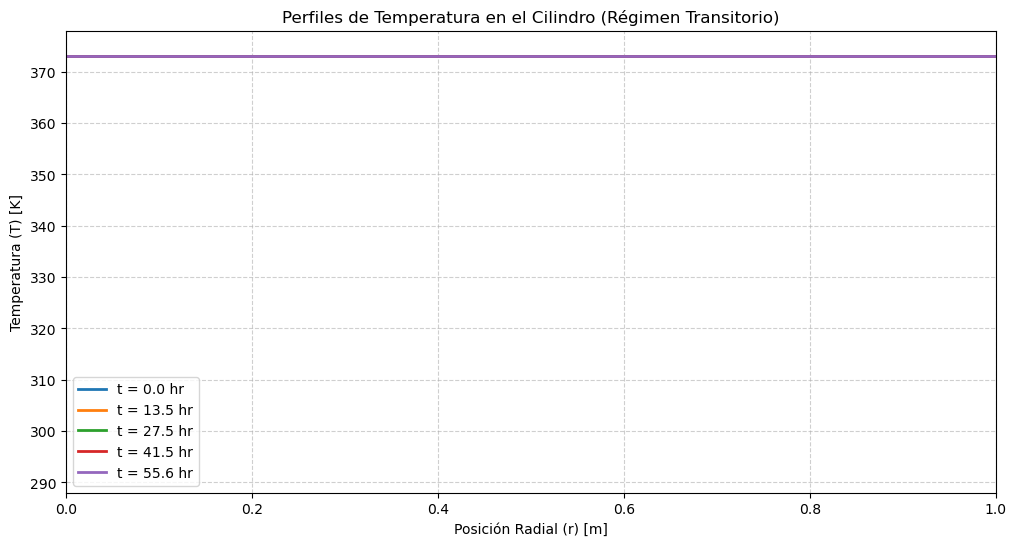

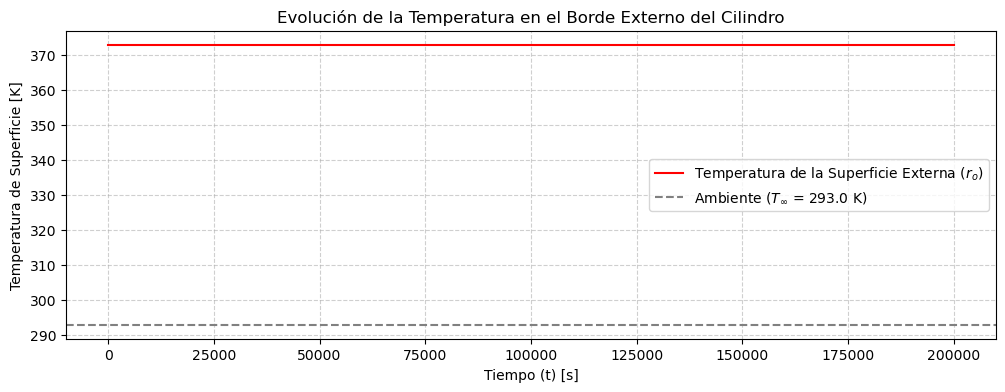

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# =========================================================================
# 1. PARÁMETROS FÍSICOS Y GEOMÉTRICOS (Definición Global)
# =========================================================================

# Parámetros físicos (Valores típicos para acero)
k = 15.0          # Conductividad térmica [W/m·K]
rho = 7800.0      # Densidad [kg/m3]
cp = 500.0        # Calor específico [J/kg·K]
alpha = k / (rho * cp)  # Difusividad térmica [m2/s] (alpha ≈ 3.846e-6)

# Condiciones térmicas
h = 10.0           # Coeficiente convectivo [W/m2·K]
T_inf = 293.0      # Temperatura del aire ambiente [K]
Ti = 373.0         # Temperatura inicial del estanque [K]

# Geometría del estanque
ri = 0.0          # Radio interno (Eje de simetría) [m]
ro = 1.0          # Radio externo [m]

# Parámetros Numéricos
N = 100                    # Número de nodos
dr = (ro - ri) / (N - 1)   # Espaciado radial [m]
r = np.linspace(ri, ro, N)


# =========================================================================
# 2. FUNCIÓN DE LA DERIVADA TEMPORAL (dT/dt = A*T + b)
# =========================================================================

def dTdt(t, T):
    
    # Se construye la matriz A y el vector b.
    A = np.zeros((N, N))
    b = np.zeros(N)

    # 5. CB1 Interna (Eje Central, i=0) - ¡CORRECCIÓN CRÍTICA!
    #    Implementación de la EDO para la singularidad (r=0): dTo/dt = alpha * 4*(T1 - T0) / dr^2
    A[0, 0] = -4 * alpha / dr**2
    A[0, 1] = 4 * alpha / dr**2
    b[0] = 0 # Gradiente nulo en el eje de simetría

    # 4. Nodos interiores (1 <= i <= N-2)
    for i in range(1, N - 1):
        r_i = r[i] # Aseguramos que r_i > 0
        
        # EDO cilíndrica discretizada
        A[i, i-1] = alpha * (1/dr**2 - 1/(2*r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(2*r_i*dr)) 
        b[i] = 0 

    # 6. CB2 Externa (Convección) (i=N-1) - Método de la Ayudantía
    
    N_last = N - 1
    
    # Anulación explícita de la EDO de Conducción en la última fila 
    # (Necesario para que la sobrescritura funcione)
    A[N_last, :] = 0
    b[N_last] = 0

    # 7. CÁLCULO DE LA DERIVADA TEMPORAL (dT) PARA NODOS INTERIORES Y CENTRALES
    dT = A @ T + b 

    # 8. IMPLEMENTACIÓN FINAL DE CB2 (SOBRESCRIBIR con la relación de la Ayudantía)
    
    # Denominador de la EDO derivada temporalmente: 3k + 2h*dr
    D = 3.0 * k + 2.0 * h * dr
    
    # Sobrescribir la derivada dT[N-1]: dT[N-1] = (4k*dT[N-2] - k*dT[N-3]) / D
    # NOTA: Usamos N_last - 1 y N_last - 2 para referirnos a T_{N-1} y T_{N-2}
    dT[N_last] = (4.0 * k * dT[N_last - 1] - 1.0 * k * dT[N_last - 2]) / D
    
    return dT


# =========================================================================
# 3. SOLUCIÓN CON SOLVE_IVP (Ajuste de Escala Temporal)
# =========================================================================

# Condición inicial: temperatura uniforme en todo el cilindro
T0 = np.ones(N) * Ti

# TIEMPO DE SIMULACIÓN AJUSTADO: Se aumenta el tiempo total a 200,000s 
# para ver el enfriamiento completo (tiempo característico es ~260,000 s).
t_span = (0, 200000) 

# Momentos en los que se evaluará la solución
t_eval = np.linspace(t_span[0], t_span[1], 100) # Más puntos de evaluación

sol = solve_ivp(
    dTdt, 
    t_span, 
    T0, 
    t_eval=t_eval,
    method='BDF', # Recomendado para sistemas rígidos como este.
    max_step=100.0 # Permitir pasos de tiempo más grandes.
)

print(f"Integración completada con éxito: {sol.success}")
print(f"Tiempo total de simulación: {sol.t[-1]:.0f} s")


# =========================================================================
# 4. GRÁFICOS DE RESULTADOS
# =========================================================================

r_grilla = np.linspace(ri, ro, N)

# --- Gráfico 1: Perfiles de Temperatura en la Pared (5 Momentos) ---
plt.figure(figsize=(12, 6))

# Seleccionar 5 perfiles temporales
indices_to_plot = np.linspace(0, len(sol.t) - 1, 5, dtype=int)

for idx in indices_to_plot:
    time = sol.t[idx]
    temperature_profile = sol.y[:, idx] 
    plt.plot(r_grilla, temperature_profile, 
             label=f't = {time/3600:.1f} hr', 
             linewidth=2)

plt.xlabel('Posición Radial (r) [m]')
plt.ylabel('Temperatura (T) [K]')
plt.title('Perfiles de Temperatura en el Cilindro (Régimen Transitorio)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xlim(ri, ro)
plt.ylim(T_inf - 5, Ti + 5)
plt.show()

# --- Gráfico 2: Evolución de la Temperatura Externa vs. Tiempo ---
T_external_surface = sol.y[N - 1, :]

plt.figure(figsize=(12, 4))
plt.plot(sol.t, T_external_surface, 
         label='Temperatura de la Superficie Externa ($r_o$)', 
         color='red')
plt.axhline(T_inf, color='gray', linestyle='--', label=f'Ambiente ($T_{{\\infty}}$ = {T_inf} K)')

plt.xlabel('Tiempo (t) [s]')
plt.ylabel('Temperatura de Superficie [K]')
plt.title('Evolución de la Temperatura en el Borde Externo del Cilindro')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

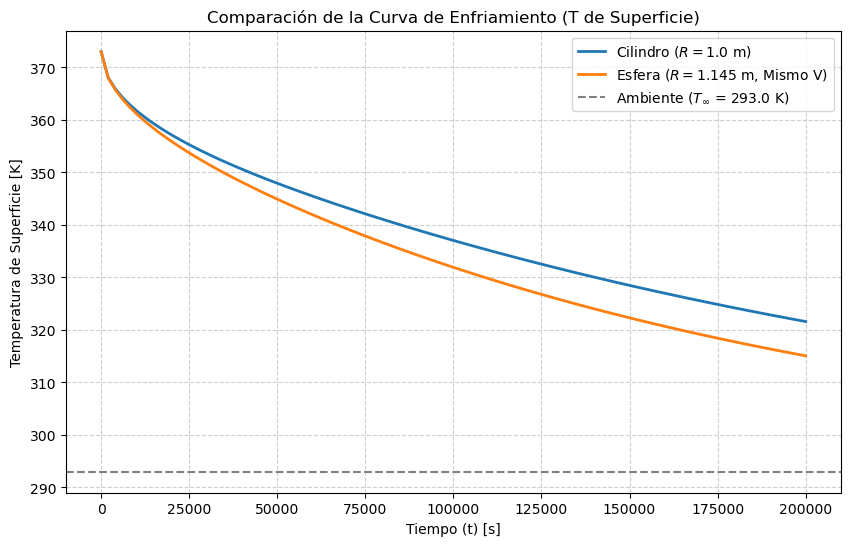

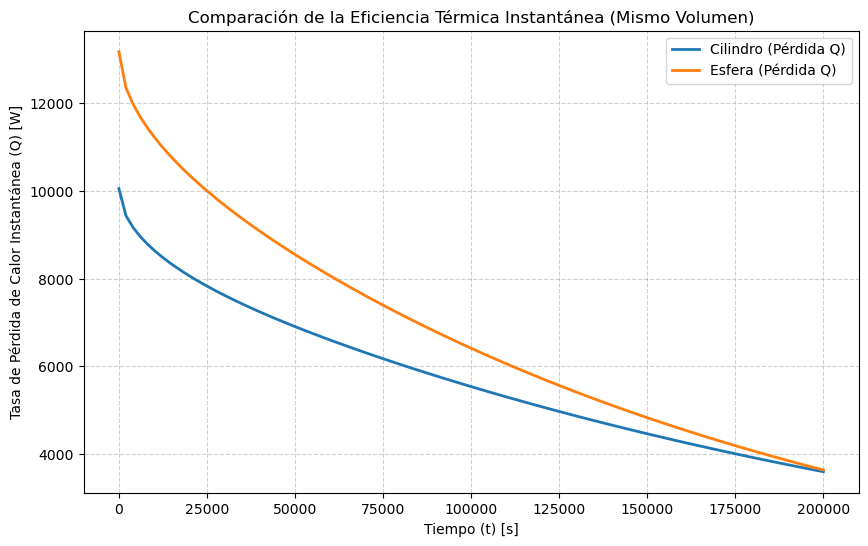

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# =========================================================================
# 1. PARÁMETROS FÍSICOS Y GEOMÉTRICOS
# =========================================================================

# Parámetros físicos (Valores típicos para acero)
k = 15.0          # Conductividad térmica [W/m·K]
rho = 7800.0      # Densidad [kg/m3]
cp = 500.0        # Calor específico [J/kg·K]
h = 10.0           # Coeficiente convectivo [W/m2·K]
T_inf = 293.0      # Temperatura del aire ambiente [K]
Ti = 373.0         # Temperatura inicial del estanque [K]

# Geometría para la COMPARACIÓN (mismo volumen V)
R_cilindro = 1.0  # Radio externo de referencia [m]
L_cilindro = 2.0  # Longitud del cilindro [m] (Asumo L=2R)

V_referencia = np.pi * R_cilindro**2 * L_cilindro  # Volumen [m3]

# Cálculo del radio de la esfera para igual volumen
R_esfera = (3 * V_referencia / (4 * np.pi))**(1/3) # R_esfera ≈ 1.145 m

# Parámetros Numéricos
N = 100                    # Número de nodos
t_span = (0, 200000)       # Tiempo total de simulación [s]

# =========================================================================
# 2. FUNCIÓN DE LA DERIVADA TEMPORAL PARA CILINDRO
# =========================================================================

def dTdt_cilindro(t, T, k, rho, cp, h, T_inf, ro, N):
    
    ri = 0.0 # Eje de simetría
    dr = (ro - ri) / (N - 1)
    r = np.linspace(ri, ro, N)
    alpha = k / (rho * cp)
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)

    # CB1 Interna (Eje Central, i=0) - Singularidad Cilíndrica: 
    # dTo/dt = alpha * 4*(T1 - T0) / dr^2
    A[0, 0] = -4 * alpha / dr**2
    A[0, 1] = 4 * alpha / dr**2
    b[0] = 0

    # Nodos interiores (1 <= i <= N-2) - EDP Cilíndrica
    for i in range(1, N - 1):
        r_i = r[i]
        
        # Coeficientes
        A[i, i-1] = alpha * (1/dr**2 - 1/(2*r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(2*r_i*dr)) 
        b[i] = 0

    # CB2 Externa (Convección) (i=N-1) - Balance de Energía
    A[N_last, N_last - 1] = alpha / dr**2
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    b[N_last] = h * T_inf / (rho * cp * dr)

    dT = A @ T + b 
    return dT


# =========================================================================
# 3. FUNCIÓN DE LA DERIVADA TEMPORAL PARA ESFERA
# =========================================================================

def dTdt_esfera(t, T, k, rho, cp, h, T_inf, ro, N):
    
    ri = 0.0 # Eje de simetría
    dr = (ro - ri) / (N - 1)
    r = np.linspace(ri, ro, N)
    alpha = k / (rho * cp)
    N_last = N - 1
    
    A = np.zeros((N, N))
    b = np.zeros(N)

    # CB1 Interna (Eje Central, i=0) - Singularidad Esférica: 
    # dTo/dt = alpha * 6*(T1 - T0) / dr^2
    A[0, 0] = -6 * alpha / dr**2
    A[0, 1] = 6 * alpha / dr**2
    b[0] = 0 

    # Nodos interiores (1 <= i <= N-2) - EDP Esférica
    for i in range(1, N - 1):
        r_i = r[i]
        
        # Coeficientes (EDP: dT/dt = alpha * [d2T/dr2 + (2/r)*dT/dr])
        A[i, i-1] = alpha * (1/dr**2 - 1/(r_i*dr)) 
        A[i, i]   = -2 * alpha / dr**2 
        A[i, i+1] = alpha * (1/dr**2 + 1/(r_i*dr)) 
        
        b[i] = 0 

    # CB2 Externa (Convección) (i=N-1) - Balance de Energía
    A[N_last, N_last - 1] = alpha / dr**2
    A[N_last, N_last] = -alpha / dr**2 - h / (rho * cp * dr)
    b[N_last] = h * T_inf / (rho * cp * dr)

    dT = A @ T + b 
    return dT


# =========================================================================
# 4. SOLUCIÓN CON SOLVE_IVP
# =========================================================================

T0 = np.ones(N) * Ti
t_eval = np.linspace(t_span[0], t_span[1], 100)

# 4.1. Solución para el Cilindro
sol_cil = solve_ivp(
    dTdt_cilindro, 
    t_span, 
    T0, 
    t_eval=t_eval,
    method='BDF',
    max_step=100.0,
    args=(k, rho, cp, h, T_inf, R_cilindro, N) # Pasando argumentos
)

# 4.2. Solución para la Esfera
sol_esf = solve_ivp(
    dTdt_esfera, 
    t_span, 
    T0, 
    t_eval=t_eval,
    method='BDF',
    max_step=100.0,
    args=(k, rho, cp, h, T_inf, R_esfera, N) # Usando R_esfera
)

# =========================================================================
# 5. CÁLCULO DE PÉRDIDAS TÉRMICAS INSTANTÁNEAS (Q_loss)
# =========================================================================

# Q_loss = A_superficie * h * (T_superficie - T_inf)
N_last = N - 1

# 5.1. Cilindro
A_cil_lateral = 2 * np.pi * R_cilindro * L_cilindro 
T_surf_cil = sol_cil.y[N_last, :]
Q_loss_cil = A_cil_lateral * h * (T_surf_cil - T_inf)

# 5.2. Esfera
A_esf = 4 * np.pi * R_esfera**2 
T_surf_esf = sol_esf.y[N_last, :]
Q_loss_esf = A_esf * h * (T_surf_esf - T_inf)


# =========================================================================
# 6. GRÁFICOS COMPARATIVOS
# =========================================================================

# 6.1. Gráfico 1: Comparación de la Curva de Enfriamiento (T_superficie vs. t)
plt.figure(figsize=(10, 6))
plt.plot(sol_cil.t, T_surf_cil, label=f'Cilindro ($R={R_cilindro}$ m)', linewidth=2)
plt.plot(sol_esf.t, T_surf_esf, label=f'Esfera ($R={R_esfera:.3f}$ m, Mismo V)', linewidth=2)

plt.axhline(T_inf, color='gray', linestyle='--', label=f'Ambiente ($T_{{\\infty}}$ = {T_inf} K)')

plt.xlabel('Tiempo (t) [s]')
plt.ylabel('Temperatura de Superficie [K]')
plt.title('Comparación de la Curva de Enfriamiento (T de Superficie)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 6.2. Gráfico 2: Comparación de la Tasa de Pérdida de Calor Instantánea (Q_loss vs. t)
plt.figure(figsize=(10, 6))
plt.plot(sol_cil.t, Q_loss_cil, label='Cilindro (Pérdida Q)', linewidth=2)
plt.plot(sol_esf.t, Q_loss_esf, label='Esfera (Pérdida Q)', linewidth=2)

plt.xlabel('Tiempo (t) [s]')
plt.ylabel('Tasa de Pérdida de Calor Instantánea (Q) [W]')
plt.title('Comparación de la Eficiencia Térmica Instantánea (Mismo Volumen)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()